<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Создание-разметки" data-toc-modified-id="Создание-разметки-1">Создание разметки</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1">Загрузка данных</a></span></li><li><span><a href="#Функции-и-константы" data-toc-modified-id="Функции-и-константы-1.2">Функции и константы</a></span><ul class="toc-item"><li><span><a href="#Get" data-toc-modified-id="Get-1.2.1">Get</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.2.2">Outliers</a></span></li><li><span><a href="#Уменьшение-категорий-в-фичах" data-toc-modified-id="Уменьшение-категорий-в-фичах-1.2.3">Уменьшение категорий в фичах</a></span></li><li><span><a href="#Разметка" data-toc-modified-id="Разметка-1.2.4">Разметка</a></span></li><li><span><a href="#Количество-потоков-в-вычислении" data-toc-modified-id="Количество-потоков-в-вычислении-1.2.5">Количество потоков в вычислении</a></span></li></ul></li><li><span><a href="#Sample_100" data-toc-modified-id="Sample_100-1.3">Sample_100</a></span></li><li><span><a href="#Sample_10k" data-toc-modified-id="Sample_10k-1.4">Sample_10k</a></span></li></ul></li><li><span><a href="#Работа-с-размеченными-данными" data-toc-modified-id="Работа-с-размеченными-данными-2">Работа с размеченными данными</a></span><ul class="toc-item"><li><span><a href="#Загрузка-размеченных-данных" data-toc-modified-id="Загрузка-размеченных-данных-2.1">Загрузка размеченных данных</a></span></li><li><span><a href="#Удаление-дубликатов" data-toc-modified-id="Удаление-дубликатов-2.2">Удаление дубликатов</a></span></li><li><span><a href="#Создание-фичей" data-toc-modified-id="Создание-фичей-2.3">Создание фичей</a></span></li><li><span><a href="#Разработка-модели" data-toc-modified-id="Разработка-модели-2.4">Разработка модели</a></span><ul class="toc-item"><li><span><a href="#Features-&amp;-Target" data-toc-modified-id="Features-&amp;-Target-2.4.1">Features &amp; Target</a></span></li><li><span><a href="#Train-&amp;-Test" data-toc-modified-id="Train-&amp;-Test-2.4.2">Train &amp; Test</a></span></li><li><span><a href="#Подбор-гипперпараметров-модели" data-toc-modified-id="Подбор-гипперпараметров-модели-2.4.3">Подбор гипперпараметров модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.5">Тестирование модели</a></span></li><li><span><a href="#Feature-importances" data-toc-modified-id="Feature-importances-2.6">Feature importances</a></span></li><li><span><a href="#Категоризация-хостов" data-toc-modified-id="Категоризация-хостов-2.7">Категоризация хостов</a></span></li></ul></li></ul></div>

In [2]:
!pip install -q catboost

# Создание разметки

In [3]:
import os
import re
import time
import math
import requests
import numpy as np
import pandas as pd
from IPython.display import HTML

from concurrent.futures import ThreadPoolExecutor

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

#import plotly
#import plotly.offline as py #working offline
#import plotly.graph_objs as go
#import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

from catboost import CatBoostClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#py.init_notebook_mode()
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Загрузка данных

In [15]:
path = "/content"

file_name_1 = 'host_info.csv'
file_name_2 = 'test_host_info.csv'

df_1 = pd.read_csv(os.path.join(path, file_name_1), header=None, names=["host", "status", "content_type"])
df_2 = pd.read_csv(os.path.join(path, file_name_2), header=None, names=["host", "status", "content_type"])

In [ ]:
df_sample = all_data.sample(n=10000, random_state=42).reset_index(drop=True).copy()

## Функции и константы

### Get

In [ ]:
def get_func(x):
    try:
        r = requests.get(x, timeout=3)#.headers['Content-Type']
        r.headers['Content-Type']
        return 0, r.status_code
    except:
        return 1, None

### Outliers

In [102]:
def drop_outliers(series, n_of_iqr=1.5):
    q75, q25 = np.nanpercentile(series,(75,25))
    iqr = q75 - q25

    max_value = q75 + (n_of_iqr * iqr)
    min_value = q25 - (n_of_iqr * iqr)

    series.loc[series < min_value] = np.nan
    series.loc[series > max_value] = np.nan

### Уменьшение категорий в фичах

In [104]:
def cat_featering(feature_name):
    series = data[feature_name].value_counts(normalize=True).copy()
    drop_outliers(series)

    data[feature_name] = data[feature_name].apply(lambda x: 'OTHER' if x in series.dropna().index else x)
    del series
    #return df_sample[feature_name].value_counts(normalize=True)

### Разметка

In [118]:
data = pd.concat((df_1, df_2)).drop_duplicates("host", ignore_index=True)
data

,host,status,content_type
0,favicon.yandex.net,404.0,NaN
1,sun3-8.userapi.com,403.0,text/html
2,mitdmp.whiteboxdigital.ru,404.0,NaN
3,passport-authproxy.taxi.yandex.net,404.0,application/json; charset=utf-8
4,hs.yandex.ru,404.0,NaN
...,...,...,...
15145,consent.trustarc.com,404.0,text/html; charset=UTF-8
15146,naeu.geo.cloudwm-cdn.com,404.0,text/html
15147,live.primis.tech,NaN,NaN
15148,game.clashroyaleapp.com,NaN,NaN


In [119]:
data["content_type"] = data.content_type.astype(str).apply(
                            lambda x: x.split(";")[0] 
                            if x.find("charset") or x.find("Charset") else str(x))

In [120]:
data

,host,status,content_type
0,favicon.yandex.net,404.0,nan
1,sun3-8.userapi.com,403.0,text/html
2,mitdmp.whiteboxdigital.ru,404.0,nan
3,passport-authproxy.taxi.yandex.net,404.0,application/json
4,hs.yandex.ru,404.0,nan
...,...,...,...
15145,consent.trustarc.com,404.0,text/html
15146,naeu.geo.cloudwm-cdn.com,404.0,text/html
15147,live.primis.tech,NaN,nan
15148,game.clashroyaleapp.com,NaN,nan


In [121]:
labels = []
for row in data.iterrows():
    if row[1].values[1] != 403.0 and row[1].values[2] == "text/html":
        labels.append(0)
    else:
        labels.append(1)

In [122]:
data["label"] = labels

In [123]:
data.label.value_counts()

0    7905
1    7245
Name: label, dtype: int64

### Количество потоков в вычислении

In [ ]:
Thread = 32

## Sample_100

```python
df['label'] = labelin_func(df)
```

## Sample_10k

```python
df_sample['label'] = labelin_func(df_sample)
```

```python
file_name = 'df_with_label_10k.csv'
df_sample.to_csv(os.path.join(path, file_name), index=True)
```

# Работа с размеченными данными

## Загрузка размеченных данных

In [ ]:
path = r'd:\Мои документы\datasets\mtc'
file_name_1 = 'df_with_label.csv'
file_name_2 = 'df_with_label_30_40.csv'
#file_name = 'host_processed.csv'
#df_sample = pd.read_csv(os.path.join(path, file_name), header = None, names=['domen_name'])

df_sample_1 = pd.read_csv(os.path.join(path, file_name_1)).drop(columns=['Unnamed: 0'])
df_sample_2 = pd.read_csv(os.path.join(path, file_name_2)).drop(columns=['Unnamed: 0'])
df_sample = pd.concat([df_sample_1, df_sample_2], ignore_index=True)
df_sample

,domen_name,url,label,status_code
0,clientservices.googleapis.com,http://clientservices.googleapis.com,0,404
1,ads.travelaudience.com,http://ads.travelaudience.com,1,None
2,4d50bf49a3c12010ab594dff7964a3ca.safeframe.goo...,http://4d50bf49a3c12010ab594dff7964a3ca.safefr...,0,404
3,c.whatsapp.net,http://c.whatsapp.net,1,None
4,dmp.gotechnology.io,http://dmp.gotechnology.io,0,403
...,...,...,...,...
19995,d280pffqtvekyf.cloudfront.net,http://d280pffqtvekyf.cloudfront.net,0,403
19996,yandex.st,http://yandex.st,0,200
19997,ocsp.usertrust.com,http://ocsp.usertrust.com,0,200
19998,cloud-api.yandex.net,http://cloud-api.yandex.net,1,None


## Удаление дубликатов

In [ ]:
df_sample.drop_duplicates(subset=['domen_name'], inplace=True, ignore_index=True)

In [ ]:
df_sample.shape

(10178, 4)

In [ ]:
df_sample['label'].value_counts(normalize=True)

0    0.768127
1    0.231873
Name: label, dtype: float64

## Создание фичей

In [124]:
data['host'] = data['host'].str.strip()
data['top_domen'] = data['host'].apply(lambda x: x.split('.')[-1])
data['2_domen'] = data['host'].apply(lambda x: x.split('.')[-2])
data['3_domen'] = data['host'].apply(lambda x: x.split('.')[-3] if len(x.split('.')) > 2 else None)

data['domen_len'] = data['host'].apply(lambda x: len(x.split('.')))
data['len_coeff'] = data['host'].apply(lambda x: len(''.join(x.split('.'))) / len(x.split('.')))

In [125]:
data.isna().sum()

host               0
status          1148
content_type       0
label              0
top_domen          0
2_domen            0
3_domen         1451
domen_len          0
len_coeff          0
dtype: int64

In [126]:
data = data.drop("status", axis=1)
data['3_domen'].fillna('EMPTY', inplace=True)

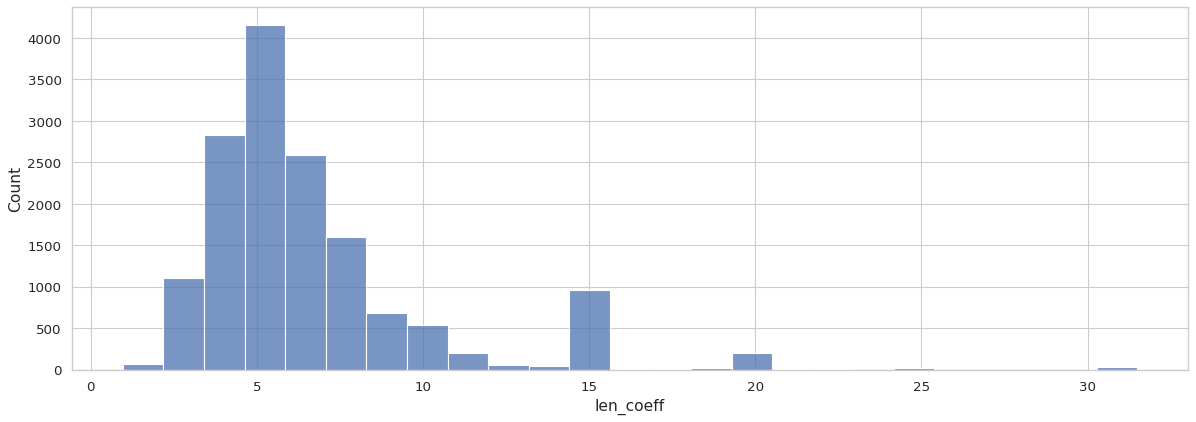

In [127]:
sns.histplot(data['len_coeff'], bins=25)
plt.show()

In [128]:
cat_featering('top_domen')
cat_featering('2_domen')
cat_featering('3_domen')

In [129]:
cat_features = ['top_domen', '2_domen', '3_domen', 'content_type']#'status_code',
num_features = ['domen_len', 'len_coeff']

data[cat_features] = data[cat_features].astype('category')

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   host          15150 non-null  object  
 1   content_type  15150 non-null  category
 2   label         15150 non-null  int64   
 3   top_domen     15150 non-null  category
 4   2_domen       15150 non-null  category
 5   3_domen       15150 non-null  category
 6   domen_len     15150 non-null  int64   
 7   len_coeff     15150 non-null  float64 
dtypes: category(4), float64(1), int64(2), object(1)
memory usage: 637.4+ KB


In [131]:
data

,host,content_type,label,top_domen,2_domen,3_domen,domen_len,len_coeff
0,favicon.yandex.net,nan,1,net,yandex,OTHER,3,5.333333
1,sun3-8.userapi.com,text/html,1,com,userapi,OTHER,3,5.333333
2,mitdmp.whiteboxdigital.ru,nan,1,ru,whiteboxdigital,mitdmp,3,7.666667
3,passport-authproxy.taxi.yandex.net,application/json,1,net,yandex,taxi,4,7.750000
4,hs.yandex.ru,nan,1,ru,yandex,OTHER,3,3.333333
...,...,...,...,...,...,...,...,...
15145,consent.trustarc.com,text/html,0,com,OTHER,OTHER,3,6.000000
15146,naeu.geo.cloudwm-cdn.com,text/html,0,com,OTHER,geo,4,5.250000
15147,live.primis.tech,nan,1,tech,OTHER,live,3,4.666667
15148,game.clashroyaleapp.com,nan,1,com,OTHER,game,3,7.000000


## Разработка модели

### Features & Target

In [132]:
features = data.drop(columns=['host', 'label'])
target = data['label']

### Train & Test

In [133]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [134]:
data.isna().sum()

host            0
content_type    0
label           0
top_domen       0
2_domen         0
3_domen         0
domen_len       0
len_coeff       0
dtype: int64

### Подбор гипперпараметров модели

In [136]:
best_score = 0
estimators, learning_r = 0, 0
start_time = time.time()

for i in np.arange(140, 152, 1):
    for j in np.arange(0.64, 0.73, 0.01):
        model = CatBoostClassifier(n_estimators=i,
                                  learning_rate=j,
                                  depth=3,
                                  cat_features=cat_features,
                                  verbose=100,
                                  random_state=12345,
                                  )

        n_scores = cross_val_score(model,
                                   X_train,
                                   y_train,
                                   scoring='precision_macro',
                                   cv=5,
                                   n_jobs=-1,
                                   error_score='raise'
                                  )

        score = np.mean(np.abs(n_scores))

        if score > best_score:
            best_score = score
            estimators = i
            learning_r = j

fit_time = time.time() - start_time

display(HTML(f'<b>Гипперпараметры n_estimators:</b> <code>{estimators}</code>, <b>learning_rate:</b> <code>{learning_r:,.2f}</code>'))
display(HTML(f'<b>Лучший precision_score: </b> <code>{best_score:,.3f}</code>'))
display(HTML(f'<b>Время обучения: </b> <code>{fit_time:,.3f}</code> c'))

## Тестирование модели

In [137]:
model = CatBoostClassifier(n_estimators=estimators,
                          learning_rate=learning_r,
                          depth=3,
                          cat_features=cat_features,
                          verbose=False,
                          random_state=12345,
                         )
model.fit(X_train, y_train)
score_test = precision_score(y_test, model.predict(X_test), average='macro')

display(HTML(f'<b>precision_score на тестовой выборке: </b> <code>{score_test:,.3f}</code>'))

# Dump Model

In [140]:
import joblib

In [141]:
with open("host_classification_model.pkl", "wb") as output:
    joblib.dump(model, output)

## Feature importances

In [138]:
fi = pd.DataFrame({'feature_importances':model.feature_importances_}, index=features.columns).sort_values(by='feature_importances', ascending=False)

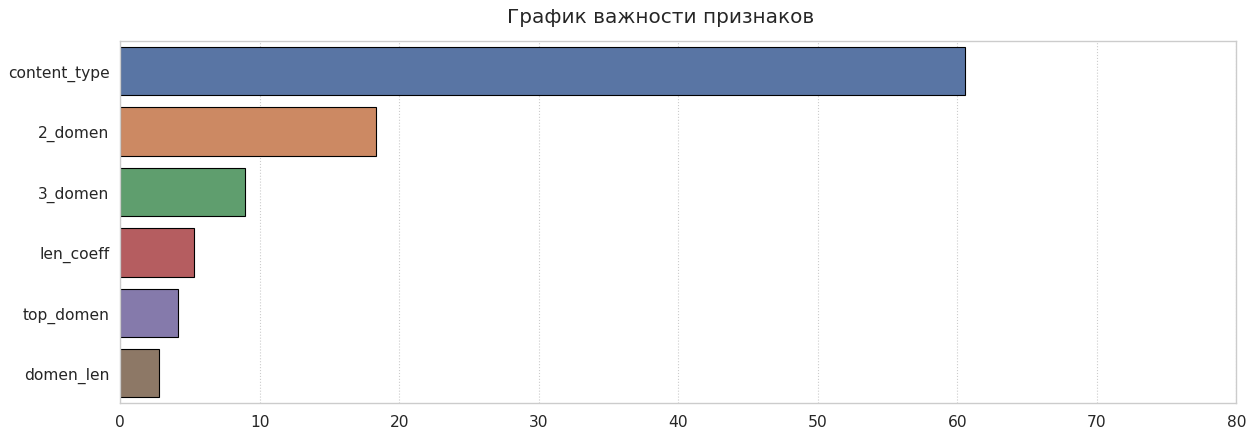

In [139]:
fig = plt.figure()
fig.suptitle(f'График важности признаков', x=.5, y=.95, fontsize=18)
sns.barplot(data=fi, x='feature_importances', y=fi.index, linewidth=1, edgecolor='black')
plt.grid(True, axis='x', linestyle=':', linewidth=1)
plt.tick_params(axis='both', direction='out', length=6, width=1)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(list(range(0,90,10)), fontsize=14)
plt.show()